# MSL dataset

## Wczytanie i prezentacja danych

In [1]:
import pandas as pd
import numpy as np
import os

# Wczytanie metadanych
metadata = pd.read_csv("labeled_anomalies.csv")
msl_channels = metadata[metadata['spacecraft'] == 'MSL']['chan_id'].tolist()

# Wczytanie danych z plików .npy
data_dir = "data/train"
all_data = {}
for channel in msl_channels:
    npy_path = os.path.join(data_dir, f"{channel}.npy")
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        if arr.ndim > 1:
            arr = arr.flatten()
        all_data[channel] = arr
    else:
        print(f"Brak pliku: {npy_path}")

# Ujednolicenie długości danych
min_len = min(len(a) for a in all_data.values())
for k in all_data:
    all_data[k] = all_data[k][:min_len]

df = pd.DataFrame(all_data)
print(df.shape)
df.head()

(24145, 27)


,M-6,M-1,M-2,S-2,P-10,T-4,T-5,F-7,M-3,M-4,...,F-5,D-14,T-9,P-14,T-8,P-11,D-15,D-16,M-7,F-8
0,-1.0,0.999976,-0.748738,-1.0,0.994353,0.0,-1.0,-0.642857,1.000046,1.0,...,-0.059837,-1.0,-0.333329,0.999426,-1.0,0.941907,-1.0,-1.0,-1.001157,-0.826087
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


## Wizualizacja wybranych kanałów

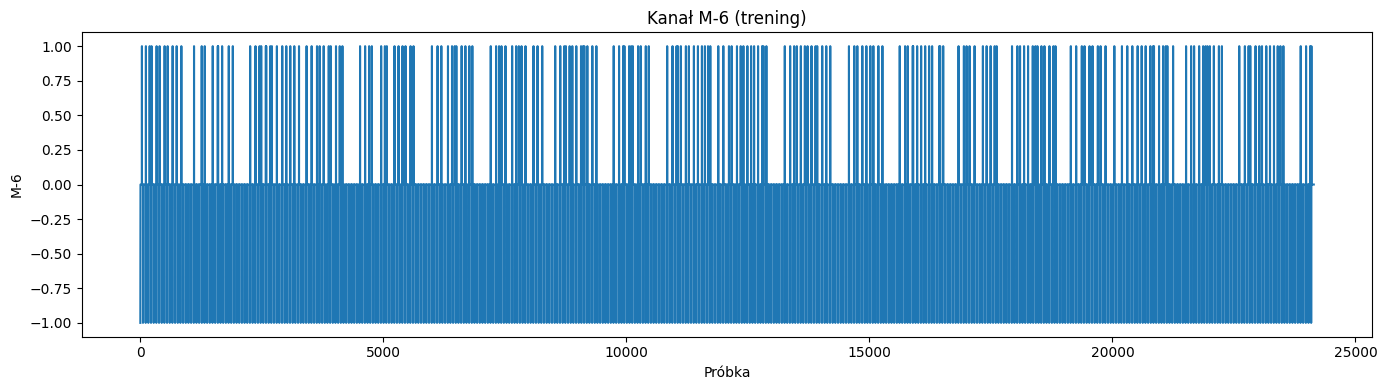

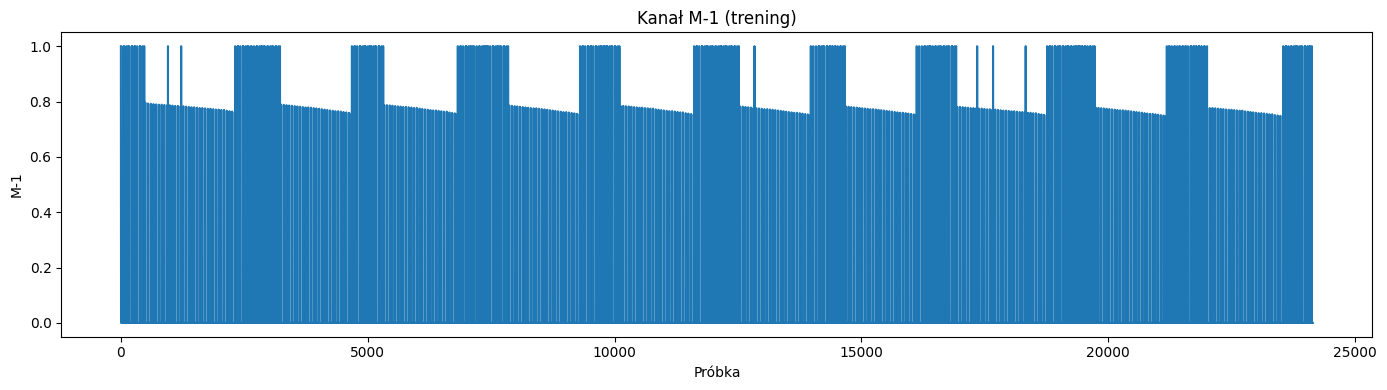

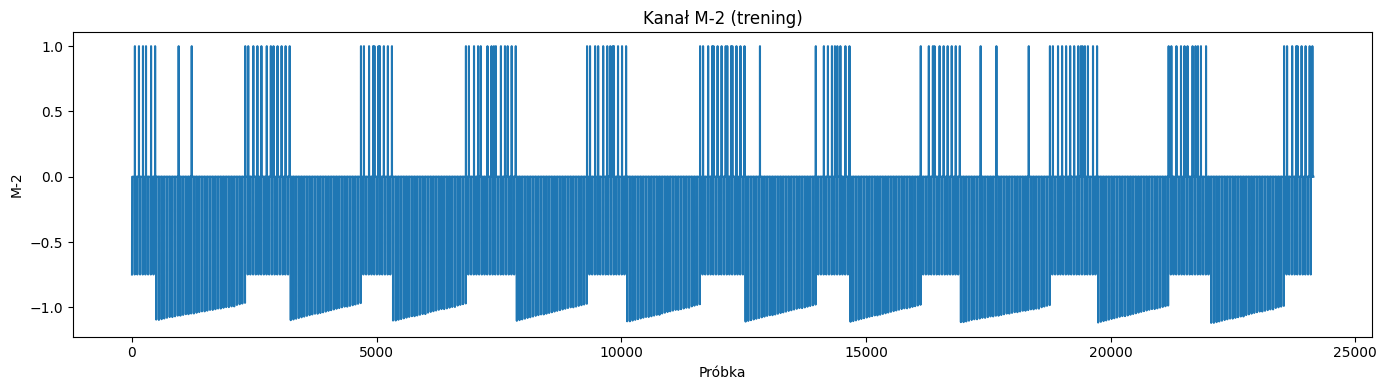

In [2]:
import matplotlib.pyplot as plt

num_channels_to_plot = 3
for channel in msl_channels[:num_channels_to_plot]:
    plt.figure(figsize=(14, 4))
    plt.plot(df[channel])
    plt.title(f'Kanał {channel} (trening)')
    plt.ylabel(channel)
    plt.xlabel('Próbka')
    plt.tight_layout()
    plt.show()

## Sprawdzenie dostępności GPU

In [3]:
import torch

if torch.cuda.is_available():
    print("GPU is available :)")
    device = torch.device("cuda")
else:
    print("GPU is NOT available, using CPU. :(")
    device = torch.device("cpu")

GPU is available :)


## Normalizacja danych

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df)
X = torch.tensor(df_normalized, dtype=torch.float32)

## Definicja autoencodera

In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(X.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, X.shape[1]),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Nauka autoencodera

In [6]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 200
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        x_batch = batch[0].to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.6f}")

Epoch 1/200, Loss: 0.007785
Epoch 2/200, Loss: 0.002297
Epoch 3/200, Loss: 0.002118
Epoch 4/200, Loss: 0.001972
Epoch 5/200, Loss: 0.001898
Epoch 6/200, Loss: 0.001857
Epoch 7/200, Loss: 0.001813
Epoch 8/200, Loss: 0.001695
Epoch 9/200, Loss: 0.001558
Epoch 10/200, Loss: 0.001477
Epoch 11/200, Loss: 0.001428
Epoch 12/200, Loss: 0.001397
Epoch 13/200, Loss: 0.001354
Epoch 14/200, Loss: 0.001339
Epoch 15/200, Loss: 0.001306
Epoch 16/200, Loss: 0.001279
Epoch 17/200, Loss: 0.001253
Epoch 18/200, Loss: 0.001201
Epoch 19/200, Loss: 0.001298
Epoch 20/200, Loss: 0.001131
Epoch 21/200, Loss: 0.001090
Epoch 22/200, Loss: 0.001063
Epoch 23/200, Loss: 0.001041
Epoch 24/200, Loss: 0.001020
Epoch 25/200, Loss: 0.001017
Epoch 26/200, Loss: 0.000995
Epoch 27/200, Loss: 0.001104
Epoch 28/200, Loss: 0.000957
Epoch 29/200, Loss: 0.000917
Epoch 30/200, Loss: 0.000911
Epoch 31/200, Loss: 0.000906
Epoch 32/200, Loss: 0.000896
Epoch 33/200, Loss: 0.000877
Epoch 34/200, Loss: 0.000857
Epoch 35/200, Loss: 0.0

## Zapis modelu do pliku

In [7]:
torch.save(model.state_dict(), "autoencoder_msl.pth")
print("Model został zapisany do 'autoencoder_msl.pth'")

Model został zapisany do 'autoencoder_msl.pth'


## Wczytanie modelu

In [8]:
model = AE().to(device)
model.load_state_dict(torch.load("autoencoder_msl.pth", map_location=device))

<All keys matched successfully>

## Autoencoder na zbiorze testowym

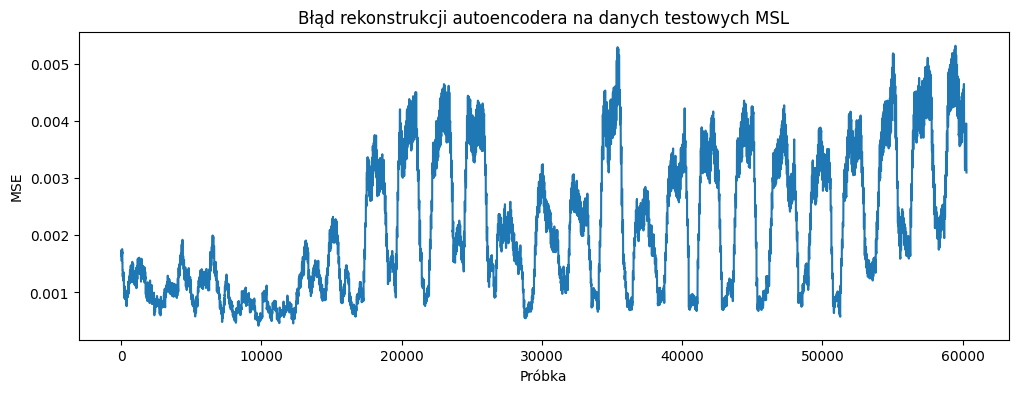

In [15]:
from scipy.ndimage import uniform_filter1d

# Dane testowe
test_data_dir = "data/test"
test_data = {}
for channel in msl_channels:
    npy_path = os.path.join(test_data_dir, f"{channel}.npy")
    if os.path.exists(npy_path):
        arr = np.load(npy_path)
        if arr.ndim > 1:
            arr = arr.flatten()
        test_data[channel] = arr
    else:
        print(f"Brak pliku: {npy_path}")

min_len = min(len(a) for a in test_data.values())
for k in test_data:
    test_data[k] = test_data[k][:min_len]

df_test = pd.DataFrame(test_data)
df_test_normalized = scaler.transform(df_test)
X_test = torch.tensor(df_test_normalized, dtype=torch.float32).to(device)

# Rekonstrukcja
model.eval()
with torch.no_grad():
    X_test_recon = model(X_test).cpu().numpy()

# Błąd rekonstrukcji
recon_error = np.mean((X_test.cpu().numpy() - X_test_recon) ** 2, axis=1)

window = 300
smooth_err = uniform_filter1d(recon_error, size=window)


plt.figure(figsize=(12,4))
plt.plot(smooth_err)
plt.title("Błąd rekonstrukcji autoencodera na danych testowych MSL")
plt.xlabel("Próbka")
plt.ylabel("MSE")
plt.show()

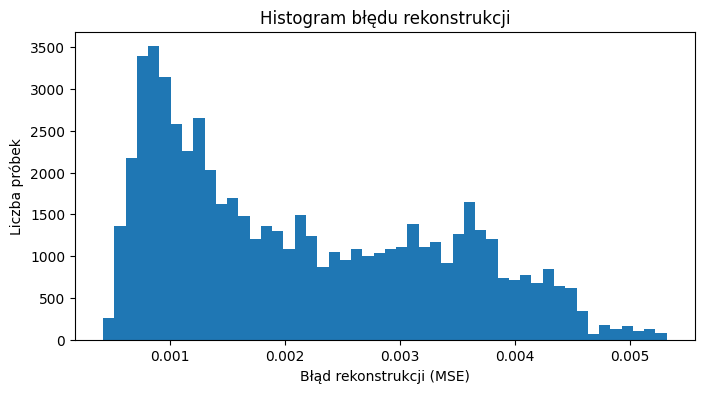

In [16]:
plt.figure(figsize=(8,4))
plt.hist(smooth_err, bins=50)
plt.title("Histogram błędu rekonstrukcji")
plt.xlabel("Błąd rekonstrukcji (MSE)")
plt.ylabel("Liczba próbek")
plt.show()

## Confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

threshold = np.percentile(smooth_err, 80)

predicted_anomaly = smooth_err > threshold

# Etykiety anomalii na podstawie labeled_anomalies.csv
true_anomaly = np.zeros(len(smooth_err), dtype=int)
for _, row in metadata[metadata['spacecraft'] == 'MSL'].iterrows():
    for seq in eval(row['anomaly_sequences']):
        start, end = seq
        true_anomaly[start:min(end+1, len(true_anomaly))] = 1

print("Confusion matrix:")
print(confusion_matrix(true_anomaly, predicted_anomaly))
print("\nClassification report:")
print(classification_report(true_anomaly, predicted_anomaly, target_names=["Normal", "Anomaly"]))

Confusion matrix:
[[45632 12056]
 [ 2592     0]]

Classification report:
              precision    recall  f1-score   support

      Normal       0.95      0.79      0.86     57688
     Anomaly       0.00      0.00      0.00      2592

    accuracy                           0.76     60280
   macro avg       0.47      0.40      0.43     60280
weighted avg       0.91      0.76      0.82     60280

